# Predicting the Norwegian Parliament Election 2025

* A model using bayesian statistics to predict the outcome of the Parliement election.

### Notes
* 169 mandates, 150 direkte, 19 utgjevningsmandater, en fra hvert valg distrikt

In [1]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
import re
pd.set_option('display.max_rows', None)

### Constants

In [2]:
valgdistrikt=np.array(["Østfold", "Akershus", "Oslo", "Hedemark", "Oppland", "Buskerud", "Vestfold","Telemark", "Aust-Agder", "Vest-Agder", "Rogaland","Hordaland","Sogn og Fjordane","Møre og Romsdal","Sør-Trøndelag","Nord-Trøndelag","Nordland","Troms", "Finnmark"])
partier= np.array(['Ap', 'Høyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rødt', 'Andre'])

In [3]:
# Latest local polling data
urls=["https://www.pollofpolls.no/?cmd=Stortinget&fylke=1",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=2",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=3",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=4",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=5",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=6",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=7",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=8",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=9",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=10",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=11",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=12", #hordaland
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=14", #sogn
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=15",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=16",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=17",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=18",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=19",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=20",
      ]

In [4]:
# 2021 Election data urls
urls_valg = ['https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=1',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=2',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=3',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=4',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=5',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=6',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=7',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=8',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=9',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=10',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=11',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=12', # 13 er ikke med
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=14',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=15',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=16',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=17',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=18',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=19',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=20']

### Data scraping Polling Data
Extracting the local polling data in each the 19 election districts from https://www.pollofpolls.no. For each Election district the polling data concists of the distribtuion of votes (%) between the parties Ap, Høyre, Frp, SV, Sp, KrF, Venstre, MDG, Rødt, Andre. 

In [7]:
def extract_local_polling_data(url_list):
    valgdistrikt=np.array(["Østfold", "Akershus", "Oslo", "Hedemark", "Oppland", "Buskerud", "Vestfold","Telemark", "Aust-Agder", "Vest-Agder", "Rogaland","Hordaland","Sogn og Fjordane","Møre og Romsdal","Sør-Trøndelag","Nord-Trøndelag","Nordland","Troms", "Finnmark"])   
    partier= np.array(['Ap', 'Høyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rødt', 'Andre'])
    df_new = pd.DataFrame({"Valgdistrikt": np.repeat(valgdistrikt, 10, axis=0), "Partier": np.tile(partier,19),"Poll-dato":np.nan})

    prosent_lister=np.array([])
    dato_lister=np.array([])

    for url in urls:
        page = urlopen(url)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table') #find all tables
        rows = table.find_all('tr') # find each row
        prosenter=[]
        for row in rows:
            cells = row.find_all(['th', 'td'])  # Find both header and data cells
            cell_texts = [cell.get_text(strip=True) for cell in cells]

            if cell_texts[0]=="Siste lokale målings":
                for i in range(1,11): #number of parties
                    tekst = cell_texts[i]
                    index = tekst.find(' (')
                    tall_string_format = tekst[0:index]
                    tall_string_med_komma = tall_string_format.replace(',','.')
                    tall = float(tall_string_med_komma)
                    prosenter.append(tall)
        prosent_lister=np.append(prosent_lister,prosenter)
        # add date to poll
        for li in soup.find_all('li'):
            sup_tag = li.find('sup')
            if sup_tag and sup_tag.text=='s':
                text = li.get_text()
                index1=text.find('(')
                index2=text.find(')')
                date=text[index1+1:index2]
                break
        dato_lister=np.append(dato_lister,[date for i in range(0,10)])


    df_new['Prosent-oppsluttning'] = prosent_lister
    df_new['Poll-dato'] = dato_lister

    return df_new
                

### Data scraping 2021 Election results
Extracting the local polling data in each the 19 election districts from https://www.pollofpolls.no. For each Election district the polling data concists of the distribtuion of votes (%) between the parties Ap, Høyre, Frp, SV, Sp, KrF, Venstre, MDG, Rødt, Andre. 

In [83]:
def extract_2021_election(url_list):
    valgdistrikt=np.array(["Østfold", "Akershus", "Oslo", "Hedemark", "Oppland", "Buskerud", "Vestfold","Telemark", "Aust-Agder", "Vest-Agder", "Rogaland","Hordaland","Sogn og Fjordane","Møre og Romsdal","Sør-Trøndelag","Nord-Trøndelag","Nordland","Troms", "Finnmark"])   
    partier= np.array(['Ap', 'Høyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rødt', 'Andre'])
    df_new = pd.DataFrame({"Valgdistrikt": np.repeat(valgdistrikt, 10, axis=0), "Partier": np.tile(partier,19)})
    df_list = []

    for url in url_list:
        page = urlopen(url)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table') #find all tables
        rows = table.find_all('tr') # find each row
        rows2 = table.find_all('td')
        liste = []
        for row in rows2:
            tall = row.text
            tall = tall.replace(" ","") # remove blank space 1000 separator
            tall = tall.replace(",",".") 
            liste.append(float(tall))
        df = pd.DataFrame()
        for i in range(0,len(liste),8):
            new_row = {'Forhånd': liste[i],
                    'Valgting': liste[i+1],
                    'Stemmer': liste[i+2],
                    'Endr-sum': liste[i+3],
                    'Fordeling': liste[i+4],
                    'Endr-for': liste[i+5],
                    'Mandat': liste[i+6],
                    'Endr-Mandat': liste[i+7]}
            df = df._append(new_row,ignore_index = True)
        df_list.append(df)

    df_conc_ver = pd.concat(df_list, ignore_index=True, axis=0)
    df_concat_final = pd.concat([df_new, df_conc_ver], axis=1)

    return df_concat_final

    

In [84]:
df_election = extract_2021_election(urls_valg)
df_poll=extract_local_polling_data(urls)

# save the data
df_poll.to_csv('data\polldata_nov24.csv', index=False)
df_election.to_csv('data\electiondata_nov24.csv', index=False)  

In [293]:
df_poll = pd.read_csv('data\polldata_nov24.csv')
df_election = pd.read_csv('data\electiondata_nov24.csv')

df_election['Fordeling'] = 0.01*df_election['Fordeling']
df_poll['Prosent-oppsluttning'] = 0.01*df_poll['Prosent-oppsluttning']
df_poll["Poll-dato"] = pd.to_datetime(df_poll["Poll-dato"],format='mixed')




df_stemmer = pd.DataFrame({"tot_stemmer_per_distrikt": np.repeat(df_election.groupby(['Valgdistrikt'],sort=False).sum()['Stemmer'].values, 10, axis=0)})
df_joined =pd.concat([df_poll['Valgdistrikt'], df_poll['Partier'], df_poll['Prosent-oppsluttning'],df_poll['Poll-dato'],df_election['Stemmer'],df_election['Fordeling'],df_stemmer["tot_stemmer_per_distrikt"] ],
                      axis=1,
                      keys=['Valgdistrikt', 'Partier','Fordeling-poll','Poll-dato','Stemmer-valg','Fordeling-valg', 'Total-stemmer'])


In [273]:
df_joined

,Valgdistrikt,Partier,Fordeling-poll,Poll-dato,Stemmer-valg,Fordeling-valg
0,Østfold,Ap,0.275,2021-10-09,49345.0,0.305
1,Østfold,Høyre,0.178,2021-10-09,30211.0,0.187
2,Østfold,Frp,0.159,2021-10-09,20527.0,0.127
3,Østfold,SV,0.077,2021-10-09,9840.0,0.061
4,Østfold,Sp,0.129,2021-10-09,22849.0,0.141
5,Østfold,KrF,0.028,2021-10-09,5414.0,0.033
6,Østfold,Venstre,0.031,2021-10-09,4771.0,0.029
7,Østfold,MDG,0.044,2021-10-09,4782.0,0.030
8,Østfold,Rødt,0.050,2021-10-09,7418.0,0.046
9,Østfold,Andre,0.031,2021-10-09,6739.0,0.042


In [269]:
df_election

,Valgdistrikt,Partier,Forhånd,Valgting,Stemmer,Endr-sum,Fordeling,Endr-for,Mandat,Endr-Mandat
0,Østfold,Ap,24817.0,24528.0,49345.0,-2200.0,0.305,-1.6,3.0,0.0
1,Østfold,Høyre,15598.0,14613.0,30211.0,-8053.0,0.187,-5.1,2.0,0.0
2,Østfold,Frp,9329.0,11198.0,20527.0,-7654.0,0.127,-4.8,1.0,-1.0
3,Østfold,SV,5525.0,4315.0,9840.0,2804.0,0.061,1.7,1.0,0.0
4,Østfold,Sp,10082.0,12767.0,22849.0,8906.0,0.141,5.4,2.0,1.0
5,Østfold,KrF,2576.0,2838.0,5414.0,-1397.0,0.033,-0.9,0.0,0.0
6,Østfold,Venstre,2408.0,2363.0,4771.0,893.0,0.029,0.5,0.0,0.0
7,Østfold,MDG,2974.0,1808.0,4782.0,590.0,0.030,0.3,0.0,0.0
8,Østfold,Rødt,4258.0,3160.0,7418.0,3983.0,0.046,2.4,0.0,0.0
9,Østfold,Andre,3675.0,3064.0,6739.0,3204.0,0.042,2.0,0.0,0.0


### Plotting the data

In [261]:
def plot_data():
    df_plot = df_poll[['Valgdistrikt','Partier','Poll-dato']]
    df_plot["Endring"] = 100*(df_poll["Prosent-oppsluttning"]-df_election["Fordeling"])   #abs(df_poll["Prosent-oppsluttning"]-df_election["Fordeling"])

    # Group by election district
    districts = df_plot["Valgdistrikt"].unique()

    # Setup subplot grid
    num_districts = len(districts)
    cols = 3  # Number of columns in the subplot grid
    rows = -(-num_districts // cols)  # Calculate rows (ceil division)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 15), constrained_layout=True)
    recent = pd.to_datetime("2024-01-01 00:00:00") # Just to categorize plots based on how old the polling data is.

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    for i, district in enumerate(districts):
        district_data = df_plot[df_plot["Valgdistrikt"] == district]
        ax = axes[i]

        if district_data['Poll-dato'].iloc[0]>=recent:
            colorchoice = 'skyblue' # color plots with new poll data blue
        else:
            colorchoice = 'lightcoral' # or this color of old polling data.

        ax.bar(district_data["Partier"], district_data["Endring"], color=colorchoice) #'skyblue'
        ax.set_title(district+ " " + str(district_data['Poll-dato'].iloc[0]))                             #Endre denne så vi ikke får klokkeslett med
        ax.set_ylim(-25, 25)
        ax.set_xticks(range(len(district_data["Partier"])))
        ax.set_xticklabels(district_data["Partier"], rotation=45)
        ax.set_ylabel("Vote %")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Endring i partioppsluttning fra valget i 2021 til nyeste poll", fontsize=16)
    plt.show()


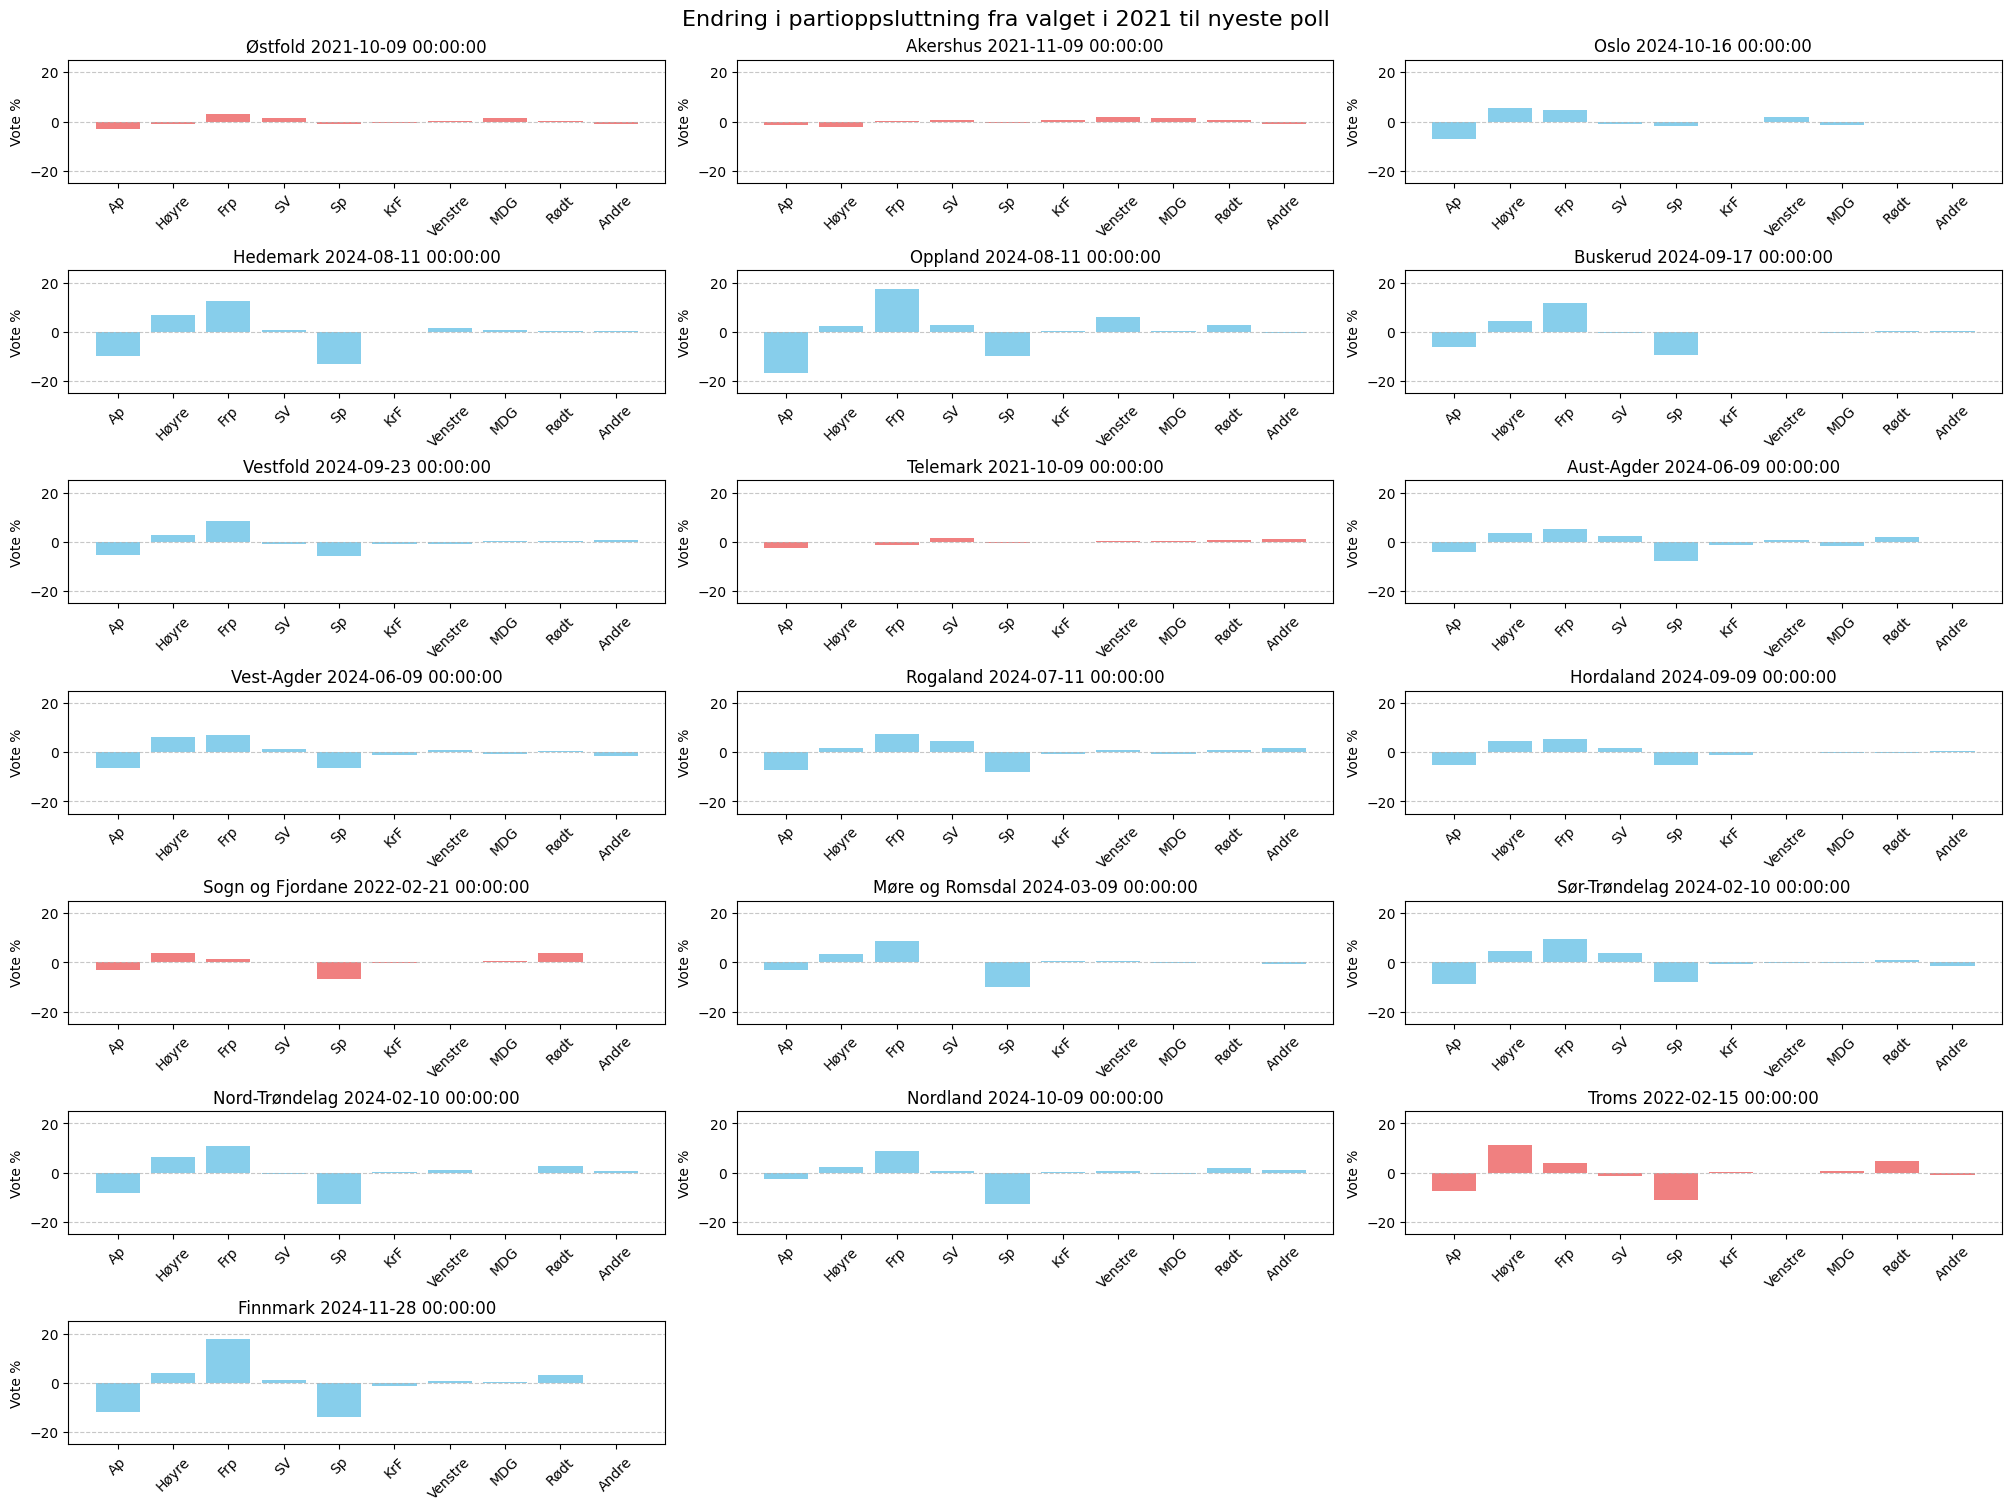

In [262]:
plot_data()

In [263]:
df_election

,Valgdistrikt,Partier,Forhånd,Valgting,Stemmer,Endr-sum,Fordeling,Endr-for,Mandat,Endr-Mandat
0,Østfold,Ap,24817.0,24528.0,49345.0,-2200.0,0.305,-1.6,3.0,0.0
1,Østfold,Høyre,15598.0,14613.0,30211.0,-8053.0,0.187,-5.1,2.0,0.0
2,Østfold,Frp,9329.0,11198.0,20527.0,-7654.0,0.127,-4.8,1.0,-1.0
3,Østfold,SV,5525.0,4315.0,9840.0,2804.0,0.061,1.7,1.0,0.0
4,Østfold,Sp,10082.0,12767.0,22849.0,8906.0,0.141,5.4,2.0,1.0
5,Østfold,KrF,2576.0,2838.0,5414.0,-1397.0,0.033,-0.9,0.0,0.0
6,Østfold,Venstre,2408.0,2363.0,4771.0,893.0,0.029,0.5,0.0,0.0
7,Østfold,MDG,2974.0,1808.0,4782.0,590.0,0.030,0.3,0.0,0.0
8,Østfold,Rødt,4258.0,3160.0,7418.0,3983.0,0.046,2.4,0.0,0.0
9,Østfold,Andre,3675.0,3064.0,6739.0,3204.0,0.042,2.0,0.0,0.0


In [296]:
df_joined.head()

,Valgdistrikt,Partier,Fordeling-poll,Poll-dato,Stemmer-valg,Fordeling-valg,Total-stemmer
0,Østfold,Ap,0.275,2021-10-09,49345.0,0.305,161896.0
1,Østfold,Høyre,0.178,2021-10-09,30211.0,0.187,161896.0
2,Østfold,Frp,0.159,2021-10-09,20527.0,0.127,161896.0
3,Østfold,SV,0.077,2021-10-09,9840.0,0.061,161896.0
4,Østfold,Sp,0.129,2021-10-09,22849.0,0.141,161896.0


In [297]:
def simulate_election(df,gamma_poll,gamma_election):

    alphas = gamma_election* df['Stemmer-valg'] + gamma_poll* df['Fordeling-poll']*df['Total-stemmer']

    df["alphas"] = alphas

    return df



In [298]:
newdf=simulate_election(df_joined,0.5,0.5)

In [299]:
newdf

,Valgdistrikt,Partier,Fordeling-poll,Poll-dato,Stemmer-valg,Fordeling-valg,Total-stemmer,alphas
0,Østfold,Ap,0.275,2021-10-09,49345.0,0.305,161896.0,46933.2000
1,Østfold,Høyre,0.178,2021-10-09,30211.0,0.187,161896.0,29514.2440
2,Østfold,Frp,0.159,2021-10-09,20527.0,0.127,161896.0,23134.2320
3,Østfold,SV,0.077,2021-10-09,9840.0,0.061,161896.0,11152.9960
4,Østfold,Sp,0.129,2021-10-09,22849.0,0.141,161896.0,21866.7920
5,Østfold,KrF,0.028,2021-10-09,5414.0,0.033,161896.0,4973.5440
6,Østfold,Venstre,0.031,2021-10-09,4771.0,0.029,161896.0,4894.8880
7,Østfold,MDG,0.044,2021-10-09,4782.0,0.030,161896.0,5952.7120
8,Østfold,Rødt,0.050,2021-10-09,7418.0,0.046,161896.0,7756.4000
9,Østfold,Andre,0.031,2021-10-09,6739.0,0.042,161896.0,5878.8880


In [285]:
df_election[df_election['Valgdistrikt']=="Østfold"]['Stemmer'].sum()

161896.0

In [287]:
df_election.groupby(['Valgdistrikt'],sort=False).sum()['Stemmer'].values

array([161896., 370301., 379565., 115131.,  98661., 143070., 139037.,
        96910.,  65835., 105148., 258868., 303472.,  62082., 148410.,
       193237.,  76643., 134228.,  92710.,  38983.])

In [ ]:
tot = sum(df_election[df_election['Valgdistrikt']=="Østfold"]['Sum']) #antall stemmer i valg distrikt totalt
andel = 1/tot*df_election[df_election['Valgdistrikt']=="Østfold"]['Sum']
andel

vekt = 0.01
alpha =  vekt*tot*andel+ (1-vekt)*tot*df_poll[df_poll["Valgdistrikt"]=='Østfold']["Prosent-oppsluttning"]*0.01

alpha2= vekt*df_election['Stemmer']+

alpha_0= sum(alpha)

exp_ap = alpha[0]/alpha_0

exp_ap

#alpha = df_election[df_election['Valgdistrikt']=="Østfold"]['Sum']*1/tot*df_election[df_election['Valgdistrikt']=="Østfold"]['Sum']+1
#alpha
#alpha_0= sum(alpha)

#exp_ap = alpha[2]/alpha_0
#exp_ap


0.2747539315748236

### Load Election district Population and Mandate distribution

In [27]:
col_names = ["Valgdistrikt","Mandater","Befolkningstall"]
df = pd.read_csv('./data/mandate-distribution.csv',header=None,names=col_names) 
df 

,Valgdistrikt,Mandater,Befolkningstall
0,Østfold,9,312152
1,Akershus,20,728803
2,Oslo,20,717710
3,Hedemark,7,202048
4,Oppland,6,174256
5,Buskerud,8,269819
6,Vestfold,7,256432
7,Telemark,6,177093
8,Aust-Agder,4,122968
9,Vest-Agder,6,196882


### Idea of the simulation

$$ Dir(\alpha) + Polling + \gamma = Dir(\bar{\alpha})$$

For each election district, we compute set a vector $\alpha$ of length 8 (number of parties). The ith element of the parameter belonging to the $k$ th election district $\alpha_i^k$ is computed as
$$

\alpha_i^k = \gamma_{\text{Valg}} n_i^k p_i^k +  \gamma_{\text{Poll}} m_i^k b_i^k + 1

$$
$n_i^k$ denotes the number of votes for political party $i$ in election district $k$, $p_i^k$ denotes the fraction of votes for the party in the election, $m_i^k$ denotes the number of votes for the party in the polling and b_i^k$ denotes the fraction of votes for the party in the polls. 

